In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from prettytable import PrettyTable
import xgboost as xgb

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_csv('preprocessed_data.csv', nrows=35000)
data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,...,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,std_price,nrm_price
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,...,NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23,-0.390533,0.015397


In [3]:
data.shape

(35000, 22)

In [4]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
print(X.shape, y.shape)

(35000, 21) (35000,)


In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)

(28000, 21) (28000,)
(7000, 21) (28000,)


### 1. Essay

In [6]:
tfidf_model = TfidfVectorizer(min_df=10, max_features=5000)
tfidf_model.fit(X_train['essay'].values)

X_train_essay_tfidf = tfidf_model.transform(X_train['essay'].values)
X_test_essay_tfidf = tfidf_model.transform(X_test['essay'].values)

print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

(28000, 5000) (28000,)
(7000, 5000) (7000,)


In [7]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [8]:
tfidf_w2v_vectors_train = []
for sentence in tqdm_notebook(X_train['essay'].values):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

In [9]:
tfidf_w2v_vectors_test = []
for sentence in tqdm_notebook(X_test['essay'].values):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

In [10]:
X_train_tfidf_w2v = pd.DataFrame(tfidf_w2v_vectors_train)
X_test_tfidf_w2v = pd.DataFrame(tfidf_w2v_vectors_test)

print(X_train_tfidf_w2v.shape)
print(X_test_tfidf_w2v.shape)

(28000, 300)
(7000, 300)


### 2. Teacher Prefix

In [11]:
def get_response_table(X_train, y_train, X_test, col):
    lst = []
    categories = X_train[col].unique()
    for i in categories:
        tot = X_train[(X_train[col]==i)][col].count()
        cat_0 = (X_train[(X_train[col]==i) & (y_train==0)][col].count())/tot
        cat_1 = (X_train[(X_train[col]==i) & (y_train==1)][col].count())/tot
        lst.append([i, cat_0, cat_1])
    response_table = pd.DataFrame(lst, columns = ['categories', 'cat_0', 'cat_1'])
    response_table.set_index('categories', inplace=True)
    
    df_train = pd.DataFrame()
    df_train['cat_0'] = list(map(lambda cat: response_table.loc[cat]['cat_0'], X_train[col].values))
    df_train['cat_1'] = list(map(lambda cat: response_table.loc[cat]['cat_1'], X_train[col].values))
    
    df_test = pd.DataFrame()
    df_test['cat_0'] = list(map(lambda cat: response_table.loc[cat]['cat_0'] if(cat in categories) else 0.5 , X_test[col].values))
    df_test['cat_1'] = list(map(lambda cat: response_table.loc[cat]['cat_1'] if(cat in categories) else 0.5 , X_test[col].values))
    
    return response_table, df_train, df_test

In [12]:
teacher_prefix_rt, teacher_prefix_train_df, teacher_prefix_test_df = get_response_table(X_train, y_train, X_test, 'teacher_prefix')

### 3. Project Grade Category

In [13]:
project_grade_category_rt, project_grade_category_train_df, project_grade_category_test_df = get_response_table(X_train, y_train, X_test,'project_grade_category')

### 4. School State

In [14]:
school_state_rt, school_state_train_df, school_state_test_df = get_response_table(X_train, y_train, X_test,'school_state')

### 5. Categories

In [15]:
project_subject_categories_rt, project_subject_categories_train_df, project_subject_categories_test_df = get_response_table(X_train, y_train, X_test,'project_subject_categories')

### 6. Subcategories

In [16]:
project_subject_subcategories_rt, project_subject_subcategories_train_df, project_subject_subcategories_test_df = get_response_table(X_train, y_train, X_test,'project_subject_subcategories')

### 7. Price

In [17]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_temp = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_temp = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_normalized = X_train_price_temp.reshape(-1,1)
X_test_price_normalized = X_test_price_temp.reshape(-1,1)

### 8. Teacher's previous projects

In [18]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_price_temp = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_price_temp = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = X_train_price_temp.reshape(-1,1)
X_test_prev_proj_norm = X_test_price_temp.reshape(-1,1)

### 9. Sentiment score

In [19]:
def sentiment_analyzer(col):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(col)
    return list(sentiment.values())

X_train_sentiment_temp = list(X_train['essay'].apply(sentiment_analyzer))
X_test_sentiment_temp = list(X_test['essay'].apply(sentiment_analyzer))

X_train_sentiment = pd.DataFrame(X_train_sentiment_temp, columns=['neg', 'neu', 'pos', 'compound'])
X_test_sentiment = pd.DataFrame(X_test_sentiment_temp, columns=['neg', 'neu', 'pos', 'compound'])

In [20]:
# Set-1
X_train_tfidf = hstack((X_train_essay_tfidf,teacher_prefix_train_df,project_grade_category_train_df,school_state_train_df,project_subject_categories_train_df,project_subject_subcategories_train_df,X_train_price_normalized,X_train_prev_proj_norm,X_train_sentiment)).tocsr()
X_test_tfidf = hstack((X_test_essay_tfidf,teacher_prefix_test_df,project_grade_category_test_df,school_state_test_df,project_subject_categories_test_df,project_subject_subcategories_test_df,X_test_price_normalized,X_test_prev_proj_norm,X_test_sentiment)).tocsr()

print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

(28000, 5016) (28000,)
(7000, 5016) (7000,)


In [21]:
# Set-2
X_train_tfidf_w2v = hstack((X_train_tfidf_w2v,teacher_prefix_train_df,project_grade_category_train_df,school_state_train_df,project_subject_categories_train_df,project_subject_subcategories_train_df,X_train_price_normalized,X_train_prev_proj_norm,X_train_sentiment)).tocsr()
X_test_tfidf_w2v = hstack((X_test_tfidf_w2v,teacher_prefix_test_df,project_grade_category_test_df,school_state_test_df,project_subject_categories_test_df,project_subject_subcategories_test_df,X_test_price_normalized,X_test_prev_proj_norm,X_test_sentiment)).tocsr()

print(X_train_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)

(28000, 316) (28000,)
(7000, 316) (7000,)


### Set-1

In [22]:
params_tfidf = {'n_estimators': [5, 10, 50, 75, 100, 200], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

xgb_clf = xgb.XGBClassifier()

clf_tfidf = GridSearchCV(xgb_clf, params_tfidf, cv=3, scoring='roc_auc', return_train_score=True)
clf_tfidf.fit(X_train_tfidf, y_train)

print(clf_tfidf.best_params_)
print(clf_tfidf.best_score_)

{'learning_rate': 0.1, 'n_estimators': 200}
0.7159355003952272


In [23]:
test_score_tfidf = clf_tfidf.cv_results_['mean_test_score']
train_score_tfidf = clf_tfidf.cv_results_['mean_train_score']

# https://www.kite.com/python/answers/how-to-split-a-list-into-n-parts-in-python
train_score_tfidf_hm = pd.DataFrame(np.array_split(train_score_tfidf, 6)).transpose()
test_score_tfidf_hm = pd.DataFrame(np.array_split(test_score_tfidf, 6)).transpose()

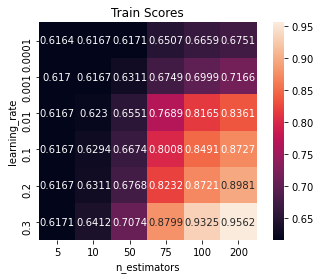

In [24]:
plt.figure()
sns.heatmap(train_score_tfidf_hm, annot=True, square=True, xticklabels=params_tfidf['n_estimators'], yticklabels=params_tfidf['learning_rate'], fmt='0.4')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('Train Scores')
plt.show()

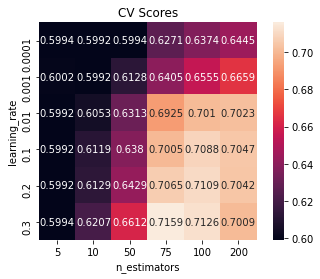

In [25]:
plt.figure()
sns.heatmap(test_score_tfidf_hm, annot=True, square=True, xticklabels=params_tfidf['n_estimators'], yticklabels=params_tfidf['learning_rate'], fmt='0.4')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('CV Scores')
plt.show()

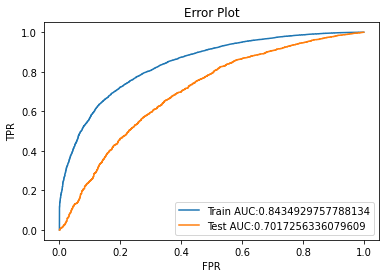

In [26]:
# training best model on best hyperparameters for set-1

best_model_tfidf = xgb.XGBClassifier(n_estimators=clf_tfidf.best_params_['n_estimators'], learning_rate=clf_tfidf.best_params_['learning_rate'])
best_model_tfidf.fit(X_train_tfidf, y_train)

y_train_predict_tfidf = best_model_tfidf.predict_proba(X_train_tfidf)[:,1]
y_test_predict_tfidf = best_model_tfidf.predict_proba(X_test_tfidf)[:,1]

fpr1_tfidf, tpr1_tfidf, thresholds1_tfidf = roc_curve(y_train, y_train_predict_tfidf)
fpr2_tfidf, tpr2_tfidf, thresholds2_tfidf = roc_curve(y_test, y_test_predict_tfidf)

plt.figure()
plt.plot(fpr1_tfidf, tpr1_tfidf, label='Train AUC:'+str(auc(fpr1_tfidf,tpr1_tfidf)))
plt.plot(fpr2_tfidf, tpr2_tfidf, label='Test AUC:'+str(auc(fpr2_tfidf,tpr2_tfidf)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

In [27]:
def find_best_threshold(threshold, fpr, tpr):
    return threshold[np.argmax(tpr*(1-fpr))]

def predict_with_best_threshold(proba, threshold):
    predictions = []
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Best threshold for TFIDF model:  0.8262303


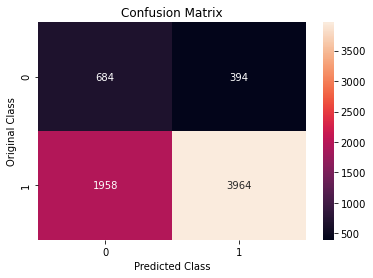

In [28]:
best_t_tfidf = find_best_threshold(thresholds1_tfidf, fpr1_tfidf, tpr1_tfidf)
print('Best threshold for TFIDF model: ', best_t_tfidf)

cm_tfidf = confusion_matrix(y_test, predict_with_best_threshold(y_test_predict_tfidf, best_t_tfidf))

plt.figure()
sns.heatmap(cm_tfidf, annot=True, fmt='1')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Confusion Matrix')
plt.show()

### Set-2

In [29]:
# finding best hyperparameter for set-2
params_w2v = {'n_estimators': [5, 10, 50, 75, 100, 200], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

xgb_clf_1 = xgb.XGBClassifier()
clf_w2v = GridSearchCV(xgb_clf_1, params_w2v, cv=3, scoring='roc_auc', return_train_score=True)
clf_w2v.fit(X_train_tfidf_w2v, y_train)

#clf1.cv_results_
print(clf_w2v.best_params_)
print(clf_w2v.best_score_)

{'learning_rate': 0.1, 'n_estimators': 200}
0.6868578704734586


In [30]:
test_score_w2v = clf_w2v.cv_results_['mean_test_score']
train_score_w2v = clf_w2v.cv_results_['mean_train_score']

# https://www.kite.com/python/answers/how-to-split-a-list-into-n-parts-in-python
train_score_hm_w2v = pd.DataFrame(np.array_split(train_score_w2v, 6)).transpose()
test_score_hm_w2v = pd.DataFrame(np.array_split(test_score_w2v, 6)).transpose()

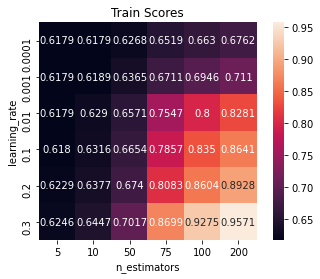

In [31]:
plt.figure()
sns.heatmap(train_score_hm_w2v, annot=True, square=True, xticklabels=params_w2v['n_estimators'], yticklabels=params_w2v['learning_rate'], fmt='0.4')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('Train Scores')
plt.show()

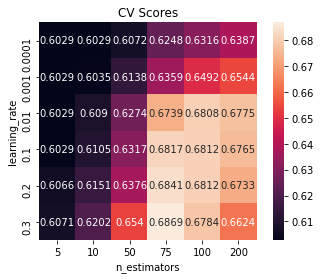

In [32]:
plt.figure()
sns.heatmap(test_score_hm_w2v, annot=True, square=True, xticklabels=params_w2v['n_estimators'], yticklabels=params_w2v['learning_rate'], fmt='0.4')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('CV Scores')
plt.show()

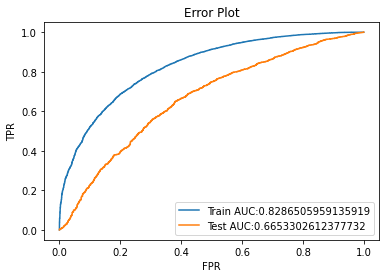

In [33]:
# training best model on best hyperparameters on set-2
best_model_w2v = xgb.XGBClassifier(n_estimators=clf_w2v.best_params_['n_estimators'], learning_rate=clf_w2v.best_params_['learning_rate'])
best_model_w2v.fit(X_train_tfidf_w2v, y_train)

y_train_predict_w2v = best_model_w2v.predict_proba(X_train_tfidf_w2v)[:,1]
y_test_predict_w2v = best_model_w2v.predict_proba(X_test_tfidf_w2v)[:,1]

#y_train_predict_w2v = y_train_predict_w2v_temp[:,1]
#y_test_predict_w2v = y_test_predict_w2v_temp[:,1]

fpr1_w2v, tpr1_w2v, thresholds1_w2v = roc_curve(y_train, y_train_predict_w2v)
fpr2_w2v, tpr2_w2v, thresholds2_w2v = roc_curve(y_test, y_test_predict_w2v)

plt.figure()
plt.plot(fpr1_w2v, tpr1_w2v, label='Train AUC:'+str(auc(fpr1_w2v,tpr1_w2v)))
plt.plot(fpr2_w2v, tpr2_w2v, label='Test AUC:'+str(auc(fpr2_w2v,tpr2_w2v)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

Best threshold for W2V model:  0.8214506


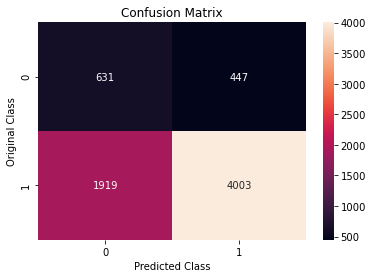

In [34]:
best_t_w2v = find_best_threshold(thresholds1_w2v, fpr1_w2v, tpr1_w2v)
print('Best threshold for W2V model: ', best_t_w2v)

cm_w2v = confusion_matrix(y_test, predict_with_best_threshold(y_test_predict_w2v, best_t_w2v))

plt.figure()
sns.heatmap(cm_w2v, annot=True, fmt='1')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Confusion Matrix')
plt.show()

In [35]:
table = PrettyTable()
table.field_names=('Vectorizer', 'Hyper-Parameter', 'AUC')
table.add_row(['TFIDF', str('n_estimators: ' + str(clf_tfidf.best_params_['n_estimators']) + ' learning_rate: ' +str(clf_tfidf.best_params_['learning_rate'])), auc(fpr2_tfidf,tpr2_tfidf)])
table.add_row(['TFIDF_W2V', str('n_estimators: ' + str(clf_w2v.best_params_['n_estimators']) + ' learning_rate: ' +str(clf_w2v.best_params_['learning_rate'])), auc(fpr2_w2v,tpr2_w2v)])
print(table)

+------------+--------------------------------------+--------------------+
| Vectorizer |           Hyper-Parameter            |        AUC         |
+------------+--------------------------------------+--------------------+
|   TFIDF    | n_estimators: 200 learning_rate: 0.1 | 0.7017256336079609 |
| TFIDF_W2V  | n_estimators: 200 learning_rate: 0.1 | 0.6653302612377732 |
+------------+--------------------------------------+--------------------+
